In [1]:
import numpy as np
import csv
import sys
sys.path.insert(1, '../Scripts')
from measfilter import getData0, errMitMat

def sxpower(s,x):
    total = 0
    length = len(s)
    for i in range(length):
        si = int(s[i])
        xi = int(x[i])
        total += si*xi
    return total

def count1(s):
    count = 0
    for i in range(len(s)):
        if s[i] == '1':
            count += 1
    return count

def gate_matrix(length, eps, m):
    size = 2**length
    mat = np.empty([size,size],dtype = np.float64)
    for row in range(size):
        for col in range(size):
            x = ("{0:0"+str(length)+"b}").format(row)
            s = ("{0:0"+str(length)+"b}").format(col)
            power = sxpower(s,x)
            mat[row,col] = ((-1)**power) * ((1 - eps)**(count1(s)*m))
    return mat

from cvxopt import matrix, solvers
def find_least_norm(ptilde): # only for one-qubit case
    # Formulation
    Q = 2*matrix(np.identity(2))
    p = -2*matrix(ptilde)

    G = matrix(np.array([[0,1],[0,-1]]),(2,2), 'd')
    h = 0.5*matrix(np.ones(2))

    A = matrix(np.array([1,0]),(1,2), 'd')
    b = matrix(0.5)

    solvers.options['show_progress'] = False
    sol=solvers.qp(Q, p, G, h, A, b)
    return sol['status'],sol['x']

def gate_denoise(p0s, lambdas):
    denoised = []
    meas_err_mat = errMitMat([lambdas[0], lambdas[1]])
    M = gate_matrix(1, lambdas[2], m)
    for p0 in p0s:
        ptilde = np.array([p0, 1 - p0])
        gate_ptilde = np.linalg.solve(meas_err_mat,ptilde)
        phat = np.linalg.solve(M,gate_ptilde)
        status, opt_phat = find_least_norm(phat)
        opt_recovered_p0 = opt_phat[0] + opt_phat[1] * (-1) ** (1 * 0) # phat(0) + phat(1)
        opt_recovered_p1 = opt_phat[0] + opt_phat[1] * (-1) ** (1 * 1) # phat(0) - phat(1)
        denoised.append(opt_recovered_p0)
        
    return denoised

In [2]:
# def gate_matrix2(length, eps, m):
#     size = 2**length
#     mat = np.empty([size,size],dtype = np.float64)
#     for row in range(size):
#         for col in range(size):
#             x = ("{0:0"+str(length)+"b}").format(row)
#             s = ("{0:0"+str(length)+"b}").format(col)
#             mat[row,col] = ((1 - eps)**(count1(s)*m))
#     return mat

# eps = 0.1
# for length in range(1,10,1):
#     print(np.linalg.matrix_rank(gate_matrix2(length, eps, 1)), 2**length)

In [2]:
# How to prove the matrix is in general full rank?
# the (1 - eps) term are the same for all rows, so we do not look at them when prove full-row rank
# Denote the matrix that only have (-1)^{s.x} as M_n where n is number of qubits
# we can see
# M_n = [M_{n-1}  M_{n-1}
#        M_{n-1}  -M_{n-1}]
# for n >= 1 and M_0 = 1
# As all entries in M_0 are all non-zero, all rows from [M_{n-1}  M_{n-1}] cannot be the multiple of rows in [M_{n-1}  -M_{n-1}]
# Then use induction to prove M_{n - 1} has full rank, which is trivially true for M_0 and M_1
# QED
 

eps = 0
m = 1
for length in range(1,4,1):
    mat = gate_matrix(length, eps, m)
    print('Num of Qubits = {length:d}, Inversable = {det:}'.format(length = length, det = (0 != np.linalg.det(mat))))
    print(mat)

Num of Qubits = 1, Inversable = True
[[ 1.  1.]
 [ 1. -1.]]
Num of Qubits = 2, Inversable = True
[[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]]
Num of Qubits = 3, Inversable = True
[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.]]


In [3]:
import csv
import sys
sys.path.insert(1, '../Scripts')
from measfilter import getData0, errMitMat


file_address = 'T1/'
m = 200
with open(file_address + 'Readout_{}{}Q{}.csv'.format(m, 'X', 1), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data1 = np.asarray([row for row in reader][0])
with open(file_address + 'Readout_{}{}Q{}.csv'.format(m, 'X', 2), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data2 = np.asarray([row for row in reader][0])

In [5]:
# # Construct ptilde
# denoised = []

# p0s = getData0(data, 128, interested_qubit)

# meas_err_mat = errMitMat([0.92545931, 0.89217367])
# M = gate_matrix(1, 0.00986768, m)
# print(M)
# for p0 in p0s:
#     ptilde = np.array([p0, 1 - p0])
#     # Remove measurement error
#     gate_ptilde = np.linalg.solve(meas_err_mat,ptilde)
#     # Remove gate error
#     phat = np.linalg.solve(M,gate_ptilde)
#     recovered_p0 = phat[0] + phat[1] * (-1) ** (1 * 0) # phat(0) + phat(1)
#     recovered_p1 = phat[0] + phat[1] * (-1) ** (1 * 1) # phat(0) - phat(1)
#     # Show result
#     print('w/  meas. error, ptilde = [{:.4f},{:.4f}]'.format(ptilde[0], ptilde[1]))
#     print('w/o meas. error, ptilde = [{:.4f},{:.4f}]'.format(gate_ptilde[0], gate_ptilde[1]))
#     print('phat = ', phat)
#     print('Recovered distribution p(0) = {:.4f}, p(1) = {:.4f}'.format(recovered_p0, recovered_p1))
#     # Find least norm
#     status, opt_phat = find_least_norm(phat)
#     opt_recovered_p0 = opt_phat[0] + opt_phat[1] * (-1) ** (1 * 0) # phat(0) + phat(1)
#     opt_recovered_p1 = opt_phat[0] + opt_phat[1] * (-1) ** (1 * 1) # phat(0) - phat(1)
#     print('Status: ', status)
#     print('phat w/ opt = [{:.4f},{:.4f}]'.format(opt_phat[0], opt_phat[1]))
#     print('Recovered distribution p(0) = {:.4f}, p(1) = {:.4f}'.format(opt_recovered_p0, opt_recovered_p1))
#     print('\n---------------------------------------------------------------------\n')
#     denoised.append(opt_recovered_p0)

In [26]:
p0s1 = getData0(data1, 64, 1)
p0s2 = getData0(data2, 64, 2)
Q1BJW = gate_denoise(p0s1, [0.92545931, 0.89217367, 0.00986768])
Q1SB = gate_denoise(p0s1, [0.92590761, 0.8994287,  0.00942002])

Q2BJW = gate_denoise(p0s2, [0.92292681, 0.88564568, 0.00760882])
Q2SB = gate_denoise(p0s2, [0.92304778, 0.88614277, 0.00612117])

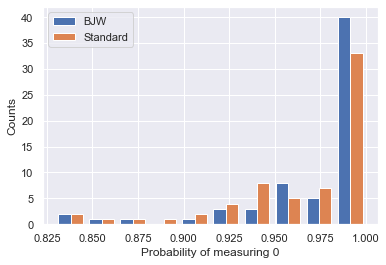

In [27]:
import matplotlib.pyplot as plt
plt.hist([Q1BJW, Q1SB], label = ['BJW', 'Standard'])
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.savefig('denoised-Qubit1.jpg')
plt.show()

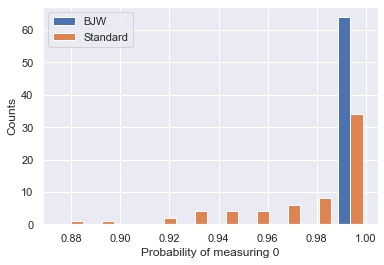

In [28]:
plt.hist([Q2BJW, Q2SB], label = ['BJW', 'Standard'])
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.savefig('denoised-Qubit2.jpg')
plt.show()

In [11]:
np.var(p0s2)

0.0002041644765995443

In [15]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

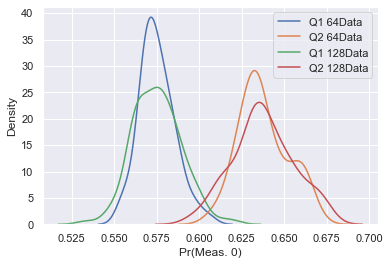

In [22]:
p0s1 = getData0(data1, 64, 1)
p0s2 = getData0(data2, 64, 2)
sns.kdeplot(p0s1, label="Q1 64Data")
sns.kdeplot(p0s2, label="Q2 64Data")
p0s1 = getData0(data1, 128, 1)
p0s2 = getData0(data2, 128, 2)
sns.kdeplot(p0s1, label="Q1 128Data")
sns.kdeplot(p0s2, label="Q2 128Data")
plt.legend()
plt.xlabel("Pr(Meas. 0)")
plt.show()

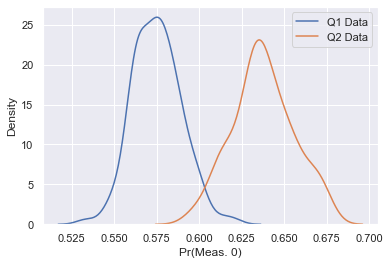

In [21]:
p0s1 = getData0(data1, 128, 1)
p0s2 = getData0(data2, 128, 2)
sns.kdeplot(p0s1, label="Q1 Data")
sns.kdeplot(p0s2, label="Q2 Data")
plt.legend()
plt.xlabel("Pr(Meas. 0)")
plt.show()